# Feature evaluation

org: **D4G**  project: **BGCO**  task: **feature evaluation**

data: labeled (engage vs. static) dataset highlighting changes in member engagement (visits per week) between first and year of engagement

## Prep the environment

In [1]:
import pandas as pd  # used to manipulate dataframes
import numpy as np # used to manipulate series

import seaborn as sns  # needed for visualing
import matplotlib.pyplot as plt  # needed for visualing

## Data Wrangling

### Load Data

In [2]:
# read in the dataframe
# see readme for version info
df_001 = pd.read_csv("D4G_BGCO_Engage_Labeled_v003.csv", encoding = "cp1252")

### Version Control

See sections below for details on how filters were created.

In [8]:
df_002 = df_001.drop(droplist_unique, axis = 1)  # features with no unique values removed

In [29]:
df_003 = df_002.drop(['member_identity', 'active', 
                      'birth_year', 'age', 'grade', 'age_category', 'member_since',
                      'city', 'd4g_valid_postal_code', 'postal_code',
                      'checkin_avg', 'member_location.y'], 
                     axis = 1)  # redundant features

In [30]:
df_004 = df_003.drop(['member_number', 'd4g_school_id'], axis = 1)  # erroneous aggregation, school_id has many -1

In [31]:
df_005 = df_004.drop(droplist_missing, axis = 1)  # missing values exceed 20%

In [32]:
df_006 = df_005.drop(imbalance, axis = 1)  # where one value count > 82%

In [36]:
df_007 = df_006.drop(['first_year'], axis = 1)  # BGCO cannot control this, irrelevant

### Save Data

In [41]:
df.to_csv("D4G_BGCO_Engage_Labeled_ForEDA_v003.csv", index = False)

## Explore Data

In [37]:
df = df_007

In [38]:
print("The training set has {0} rows and {1} columns".format(df.shape[0], df.shape[1]))

The training set has 1814 rows and 8 columns


In [39]:
df.columns

Index(['d4g_member_id', 'label', 'member_location.x', 'sex', 'Y1_Age',
       'checkin_total', 'season_most', 'club_km'],
      dtype='object')

### Feature Summary

Proposed
* visits per week or month to clubhouse in y1 (find out if being a 'busy' clubhouse is a factor)
* number of programs offered by clubhouse
* when during the week do members visit

Key
* d4g_member_id (primary key)

Behaviour
* label (target feature)
* total number of visits by member in y1
* visits grouped by fall or winter

Service
* first_year: the first year of engagement
* member_location: clubhouse visited

Characteristic
* Y1_Age: age at first_year
* sex
* neighborhood (partial)
* club_km (partial)
* diff_club_min (partial)

Conditional Inclusions
* first_language (only 60% of the dataset) (missing data)
* distance to clubhouse (only 77% of the dataset) (missing data), some of these are erroneous


### Unique Values

Number of unique values, if 1 or less should be removed.

In [6]:
df.nunique()

d4g_member_id              1814
label                         2
first_year                   10
member_number              1720
mem_type                      2
active                        2
member_location.x             8
city                         21
province                      2
postal_code                1020
d4g_valid_postal_code       586
birth_year                   18
sex                           2
d4g_school_id               167
grade                        13
first_language                7
second_language               9
other_languages               6
ethnic_origin                 1
member_since                911
last_renewal_date           650
member_type                   0
member_fee_paid_to_date       1
member_fee_outstanding        1
member_fees_total             1
suspended                     2
camper                        2
camp_year                     2
member_identity            1814
subsidy                       1
hear_about                    2
family_i

Create a list of columns with low unique value counts, then remove then from the dataset (df_001 -> df_002)

In [7]:
droplist_unique = [i for i in df.columns if df[i].nunique('label') < 2]
droplist_unique

['ethnic_origin',
 'member_type',
 'member_fee_paid_to_date',
 'member_fee_outstanding',
 'member_fees_total',
 'subsidy']

### Erroneous Aggregation

Special case: Member numbers
* the duplicates in this feature seem to correspond to different members
* thus inclusion erroneously reduces variability, without adding qualifiers

In [ ]:
duplicates = df.duplicated('member_number', keep = False)
df_duplicates = df[duplicates]
df_duplicates[['member_number','first_year', 'sex', 'Y1_Age']].sort_values(by = 'member_number').head(6)

### Missing Values

How many features/attributes have missing values? Which ones?
* df_004 used to exclude if missing > 20%

In [13]:
print("A total of ", len(df.columns[df.isnull().any()]), "features have missing values")
print("They are:", df.columns[df.isnull().any()])

A total of  8 features have missing values
They are: Index(['first_language', 'second_language', 'other_languages',
       'last_renewal_date', 'camper', 'camp_year', 'hear_about',
       'family_identity'],
      dtype='object')


How many are missing?

In [14]:
miss = df.isnull().sum() #number of missing entries in each feature / number of total entries
miss = miss[miss > 0] # keep only those that are greater than "0 / number of total entries"
miss.sort_values(inplace=True) # sort by percentage ascending
miss # display

camper                  1
camp_year               1
hear_about              1
first_language        680
last_renewal_date     741
family_identity      1357
second_language      1773
other_languages      1803
dtype: int64

What is the percentage of missing values?

In [15]:
miss = df.isnull().sum()/len(df) #number of missing entries in each feature / number of total entries
miss = miss[miss > 0] # keep only those that are greater than "0 / number of total entries"
miss.sort_values(inplace=True) # sort by percentage ascending
miss # display

camper               0.000551
camp_year            0.000551
hear_about           0.000551
first_language       0.374862
last_renewal_date    0.408490
family_identity      0.748071
second_language      0.977398
other_languages      0.993936
dtype: float64

Visualising missing values

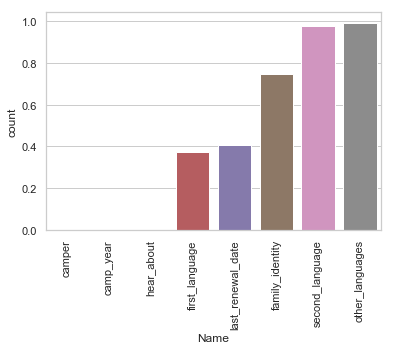

In [16]:
miss = miss.to_frame() # convert to a dataframe
miss.columns = ['count'] # rename the column as 'count'
miss.index.names = ['Name'] # rename index as 'Name'
miss['Name'] = miss.index # create a new column of the index

#plot the missing value count
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'Name', y = 'count', data=miss)
plt.xticks(rotation = 90)
plt.show()

Remove if exceeds 25%

In [17]:
droplist_missing = [i for i in df.columns if df[i].isnull().sum()/len(df[i]) > 0.25]
droplist_missing

['first_language',
 'second_language',
 'other_languages',
 'last_renewal_date',
 'family_identity']

### Feature Balance

Create a smaller subset of 

In [20]:
balance_check = [i for i in df.columns if df[i].nunique() < 50]
df_balance_check = df[balance_check]

df_balance_check.nunique()

label                 2
first_year           10
mem_type              2
member_location.x     8
province              2
sex                   2
suspended             2
camper                2
camp_year             2
hear_about            2
Y1_Age               18
checkin_total        39
season_most           2
member_location.y     8
dtype: int64

Define a function to remove columns that have a value count exceeding 90%

In [21]:
def imbalanced_features(df_to_check, threshold = 0.9):
    """
    Returns a list of columns where at least one value count exceeds threshold
    """
    
    df_to_output = df_to_check
    
    for h in df_to_check.columns:
        col_val_count = pd.value_counts(df_to_check[h].values, sort=False)  # returns value counts by column
        
        count = 0
        
        for i in col_val_count.values:
            if i / df_to_check.shape[0] > threshold:
                count += 1
        
        if count > 0:
            df_to_output = df_to_output.drop(h, axis = 1)
            
    list_to_output = df_to_check.drop(df_to_output.columns, axis = 1).columns
            
    return list_to_output

Use function to create list of imbalanced features

In [22]:
imbalance = imbalanced_features(df_balance_check, 0.82)
imbalance

Index(['mem_type', 'province', 'suspended', 'camper', 'camp_year',
       'hear_about'],
      dtype='object')

Update df by dropping imbalanced features

In [23]:
categorical_features = df_balance_check.drop(imbalance, axis = 1).columns

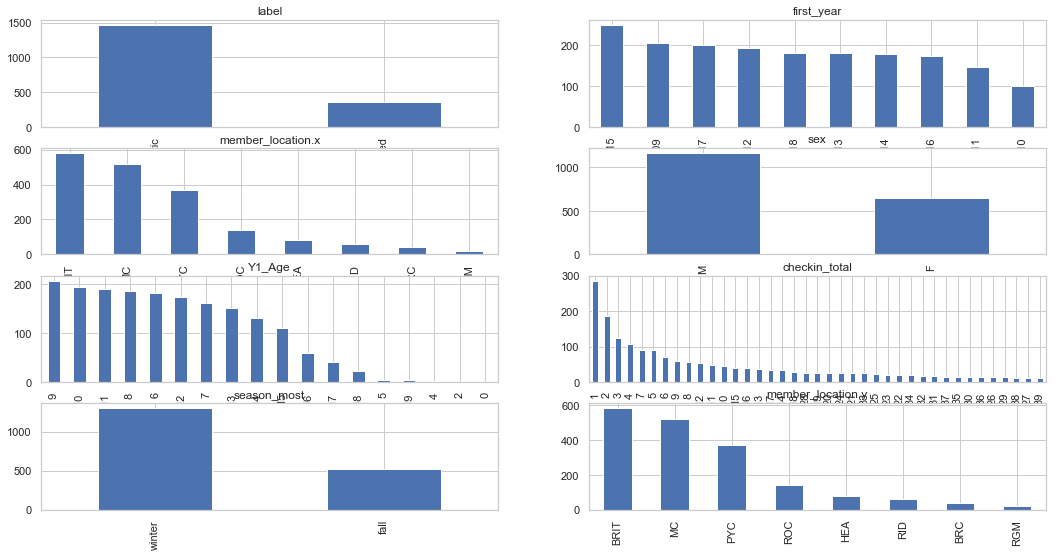

In [24]:
# plot parameters
ROWS, COLS = 4, 2  # set number of rows and columns for figures

fig, ax = plt.subplots(ROWS, COLS, figsize=(18, 9))
row, col = 0, 0
for i, categorical_feature in enumerate(categorical_features):
    if col == COLS - 1:
        row += 1
    col = i % COLS
    df[categorical_feature].value_counts().plot('bar', ax=ax[row, col]).set_title(categorical_feature)